# Logistic Regression

The logistic regression model as described in the README.md file will be used to predict the quality of transit infrastructure based on GDP per capita. In the data file, transit infrastructure is evaluated on a scale from 1 to 7, where 1 is the worst and 7 is the best. There are four types of transportation being evaluated: air, rail, road, and port. For the purposes of logistic regression, I will be taking the average of the four and if the value comes out to above 4, then we will call that good quality transit infrstructure (1). That means if the value is equal to or below 4, then the transit quality is poor (0).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Cleaning Up Data + Isolate Quality of Transit and GDP

In [2]:
#read csv file with all country transit and socioeconomic data
df = pd.read_csv("CountryData1.csv")

In [3]:
# clean up data file

# dependent variable: Average of transit quality, 1 if <4, 0 if <=4
# isolate the following independent variables:
#		Quality of air transport infrastructure
#		Quality of port infrastructure
#		Quality of railroad infrastructure
#		Quality of roads
#		GDP per capita

row_ind = [12, 14, 16, 18, 22]
col_filled = ~df.loc[row_ind].isin([".."]).any() # only keep countries with nonempty rows

fil_df = df.loc[row_ind, col_filled] # create new data table with isolated rows
fil_df.head()

,Unnamed: 0,Time,Time Code,Indicator Name,Indicator Code,Albania [ALB],Algeria [DZA],Angola [AGO],Argentina [ARG],Armenia [ARM],...,Turkey [TUR],Uganda [UGA],Ukraine [UKR],United Kingdom [GBR],United States [USA],Uruguay [URY],"Venezuela, RB [VEN]",Vietnam [VNM],Zambia [ZMB],Zimbabwe [ZWE]
12,12,2013,YR2013,Quality of air transport infrastructure [value...,QA.AIR.TRANS.IN,4.31,3.01,3.38,3.56,4.53,...,5.53,3.58,3.84,5.61,5.95,4.25,2.99,4.04,3.54,3.32
14,14,2013,YR2013,Quality of port infrastructure [value: 1 = wor...,QA.PORT.TRANS.IN,3.47,2.7,2.94,3.67,3.05,...,4.34,3.41,3.71,5.68,5.67,4.7,2.53,3.68,3.49,4.09
16,16,2013,YR2013,Quality of railroad infrastructure [value: 1 =...,QA.RAIL.TRANS.IN,1.18,2.33,1.67,1.7,2.6,...,3.12,1.53,4.47,5.01,4.89,1.23,1.58,2.97,2.11,2.27
18,18,2013,YR2013,Quality of roads [value: 1 = worst to 7 = best],QA.ROAD.TRANS.IN,3.85,3.29,2.35,3.07,3.68,...,4.86,3.04,2.14,5.31,5.68,3.49,2.65,3.08,3.37,3.28
22,22,2013,YR2013,GDP per capita (current US$),NY.GDP.PCAP.CD,4413.063383,5979.60139,5057.747878,12963.67577,3680.166922,...,12578.18786,818.2854274,4129.896973,43426.29814,53409.75078,18335.25948,12403.1467,2359.517365,1820.718548,1362.300668


In [4]:
# transform data file and delete time/labels for correlations
df_transposed = fil_df.T
df_transposed.columns = df_transposed.iloc[3]
df_corr = df_transposed.iloc[5:,:]
df_corr = df_corr.astype(float)
df_corr.head()

df_corr['infra_avg'] = df_corr[[
    'Quality of air transport infrastructure [value: 1 = worst to 7 = best]',
    'Quality of port infrastructure [value: 1 = worst to 7 = best]',
    'Quality of railroad infrastructure [value: 1 = worst to 7 = best]',
    'Quality of roads [value: 1 = worst to 7 = best]'
]].mean(axis=1)
df_corr['poor_infra'] = (df_corr['infra_avg'] > 4.0).astype(int) # 1 if >4, 0 else
print(df_corr['poor_infra'].value_counts()) # how many 1s and 0s
df_corr.head()

poor_infra
0    60
1    50
Name: count, dtype: int64


Indicator Name,Quality of air transport infrastructure [value: 1 = worst to 7 = best],Quality of port infrastructure [value: 1 = worst to 7 = best],Quality of railroad infrastructure [value: 1 = worst to 7 = best],Quality of roads [value: 1 = worst to 7 = best],GDP per capita (current US$),infra_avg,poor_infra
Albania [ALB],4.31,3.47,1.18,3.85,4413.063383,3.2025,0
Algeria [DZA],3.01,2.70,2.33,3.29,5979.601390,2.8325,0
Angola [AGO],3.38,2.94,1.67,2.35,5057.747878,2.5850,0
Argentina [ARG],3.56,3.67,1.70,3.07,12963.675770,3.0000,0
Armenia [ARM],4.53,3.05,2.60,3.68,3680.166922,3.4650,0


### Using the sci-kit learn logistic regression

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [12]:
# split X and y + train/test data

# split X and target y
X = df_corr.iloc[:,0:6]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Use this X_scaled in your model
y = df_corr.iloc[:,6]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.35, random_state=50)


In [13]:
# train the model
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        17

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39



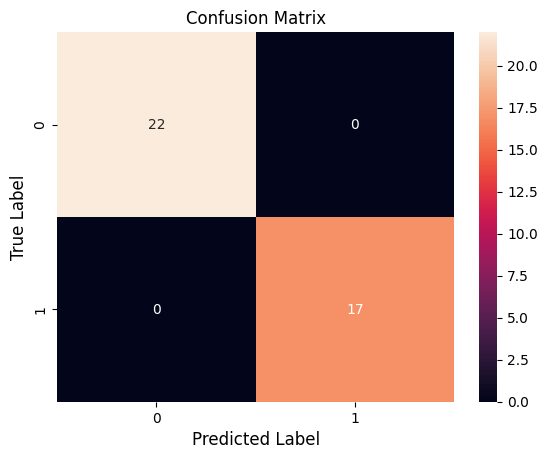

In [14]:
# obtain predicted values
y_pred = logmodel.predict(X_test)

cm = confusion_matrix(y_test, y_pred) # confusion matrix
plt.figure()
sns.heatmap(pd.DataFrame(cm), annot=True, fmt='g', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

print(classification_report(y_test, y_pred))

### Conclusion: Using the sklearn package

With the sklearn logistic regression package, we are able to predict the quality of transit infrastructure from the GDP per capita. This model is quite accurate, since it has a 100% prediction rate. Higher GDP per capita generally indicates a wealthier, more developed country, so it would make sense that countries with a higher GDP would also have more developed transit infrastructure. When using large values such as GDP or population, the inputs have to scaled so that it does not cause an overflow warning in the sigmoid function. To understand how logistic regression uses gradietn descent, computes the gradient, and updates the weights, we can also implement the logistic regression algorithm from scratch.

### Implementing the logistic regression from scratch

In [30]:
class LogRegScratch:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters

    def _sigmoid(self, x):
        # sigmoid converts values to between 0 and 1
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # gradient descent
        for _ in range(self.n_iters):
            model = np.dot(X, self.weights) + self.bias # linear model
            predictions = self._sigmoid(model) # apply sigmoid

            # compute gradients
            dw = (1/n_samples) * np.dot(X.T, (predictions - y))
            db = (1/n_samples) * np.sum(predictions - y)

            # update weights
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_prob(self, X):
        model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(model)

    def predict(self, X):
        prob = self.predict_prob(X)
        return [1 if i > 0.5 else 0 for i in prob]


In [35]:
# train and get predictions from regression implementation
logmodel_scratch = LogRegScratch(learning_rate=0.1, n_iters=1000)
logmodel_scratch.fit(X_train, y_train)
y_pred_scratch = logmodel_scratch.predict(X_test)

Accuracy: 1.00


Text(50.722222222222214, 0.5, 'True Label')

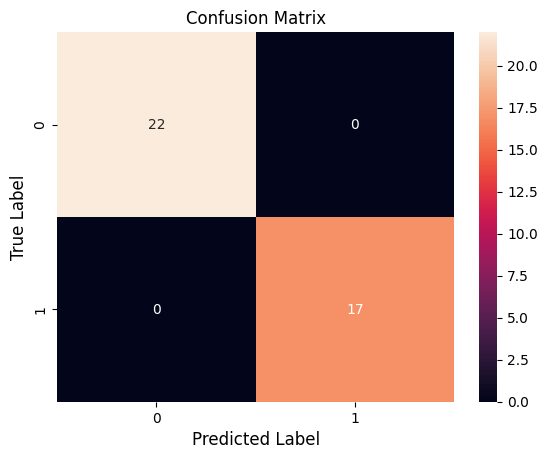

In [36]:
# assess accuracy
accuracy = np.mean(y_pred_scratch == y_test)
print(f"Accuracy: {accuracy:.2f}")

cm_scratch = confusion_matrix(y_test, y_pred_scratch) # confusion matrix
plt.figure()
sns.heatmap(pd.DataFrame(cm_scratch), annot=True, fmt='g', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

### Conclusion: Implementation from scratch

Like the sci-kit learn package, an implementation from scratch results in the same prediction accuracy of 100%. For the purposes of predicting the quality of transporation infrastructure on a binary scale in a certain country, the logistic regression model is a solid choice.